#IS 470 Lab 7: SVM and Neural Network

---

##Part 1. SVM and Neural Network for Numeric Prediction
<br>
In order for a health insurance company to make money, it needs to collect more
in yearly premiums than it spends on medical care to its beneficiaries. As a result, insurers invest a great deal of time and money in developing models that accurately forecast medical expenses for the insured population.<br>
<br>
Medical expenses are difficult to estimate because the most costly conditions are rare and seemingly random. Still, some conditions are more prevalent for certain segments of the population. For instance, lung cancer is more likely among smokers than non-smokers, and heart disease may be more likely among the obese.<br>
<br>
The goal of this analysis is to use patient data to estimate the average medical
care expenses for such population segments. These estimates can be used to create actuarial tables that set the price of yearly premiums higher or lower, 
depending on the expected treatment costs.<br>
<br>
The insurance data set has 1338 observations of 7 variables.
<br>
We will use this file to predict the medical expenses.
<br>
<br>
VARIABLE DESCRIPTIONS:<br>
age:	      age in years<br>
sex:	      gender<br>
bmi:	      body mass index<br>
children:	how many children do they have?<br>
smoker:	  do they smoke?<br>
region:	  geographic region<br>
expenses:	yearly medical expenses<br>

Target variable: **expenses**

### Upload and clean data

In [ ]:
# Upload data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving insurance.csv to insurance (2).csv
User uploaded file "insurance.csv" with length 50264 bytes


In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# Read data
insurance = pd.read_csv("insurance.csv")
insurance

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [ ]:
# Show the head rows of a data frame
insurance.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [ ]:
# Examine variable type
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [ ]:
# Change categorical variables to "category"
insurance['sex'] = insurance['sex'].astype('category')
insurance['smoker'] = insurance['smoker'].astype('category')
insurance['region'] = insurance['region'].astype('category')

In [ ]:
# Examine variable type
insurance.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
expenses     float64
dtype: object

In [ ]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

Text(0.5, 1.0, 'Histogram of expenses in the insurance data set')

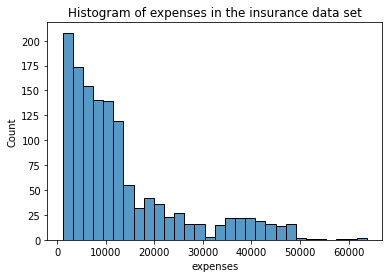

In [ ]:
# Data exploration: some examples
# Histogram of insurance expenses
snsplot = sns.histplot(x='expenses', data = insurance)
snsplot.set_title("Histogram of expenses in the insurance data set")

In [ ]:
# exploring relationships among all numeric variables: correlation matrix
insurance.corr()

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


### Partition the data set

In [ ]:
# Create dummy variables
insurance = pd.get_dummies(insurance, columns=['sex','smoker','region'], drop_first=True)
insurance

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
3,33,22.7,0,21984.47,1,0,1,0,0
4,32,28.9,0,3866.86,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,31.0,3,10600.55,1,0,1,0,0
1334,18,31.9,0,2205.98,0,0,0,0,0
1335,18,36.9,0,1629.83,0,0,0,1,0
1336,21,25.8,0,2007.95,0,0,0,0,1


In [ ]:
insurance['age2'] = insurance['age'] ** 2
insurance

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age2
0,19,27.9,0,16884.92,0,1,0,0,1,361
1,18,33.8,1,1725.55,1,0,0,1,0,324
2,28,33.0,3,4449.46,1,0,0,1,0,784
3,33,22.7,0,21984.47,1,0,1,0,0,1089
4,32,28.9,0,3866.86,1,0,1,0,0,1024
...,...,...,...,...,...,...,...,...,...,...
1333,50,31.0,3,10600.55,1,0,1,0,0,2500
1334,18,31.9,0,2205.98,0,0,0,0,0,324
1335,18,36.9,0,1629.83,0,0,0,1,0,324
1336,21,25.8,0,2007.95,0,0,0,0,1,441


In [ ]:
# add an indicator for BMI >= 30
insurance.loc[insurance['bmi'] >= 30, 'bmi30'] = 1
insurance.loc[insurance['bmi'] < 30, 'bmi30'] = 0
insurance['bmi30'] = insurance['bmi30'].astype('category')

In [ ]:
# add an interaction effects bmi30*smoker
insurance['bmi30_smoker'] = insurance['bmi30'].astype(float) * insurance['smoker_yes'].astype(float)

In [ ]:
# Partition the data
target = insurance['expenses']
predictors = insurance.drop(['expenses'],axis=1)
predictors_train_insurance, predictors_test_insurance, target_train_insurance, target_test_insurance = train_test_split(predictors, target, test_size=0.3, random_state=0)
print(predictors_train_insurance.shape, predictors_test_insurance.shape, target_train_insurance.shape, target_test_insurance.shape)

(936, 11) (402, 11) (936,) (402,)


Text(0.5, 1.0, 'Histogram of expenses in the training data set')

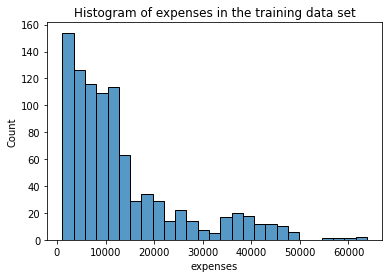

In [ ]:
# Examine the distribution of target variable for training data set
snsplot = sns.histplot(data = target_train_insurance)
snsplot.set_title("Histogram of expenses in the training data set")

Text(0.5, 1.0, 'Histogram of expenses in the testing data set')

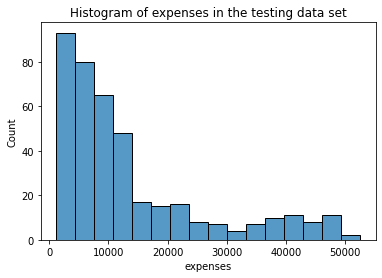

In [ ]:
# Examine the distribution of target variable for testing data set
snsplot = sns.histplot(data = target_test_insurance)
snsplot.set_title("Histogram of expenses in the testing data set")

### SVM model

In [ ]:
# Build a SVM model with default setting (C = 1.0)
model_svm1 = SVR()
model_svm1.fit(predictors_train_insurance, target_train_insurance)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_insurance = model_svm1.predict(predictors_test_insurance)

In [ ]:
# Examine the evaluation results on testing data: MAE and RMSE
MAE = mean_absolute_error(target_test_insurance, prediction_on_test_insurance)
RMSE = mean_squared_error(target_test_insurance, prediction_on_test_insurance, squared=False)
print("MAE", MAE)
print("RMSE", RMSE)

MAE 8630.251825783458
RMSE 13166.62224632229


In [ ]:
# Build a SVM model with C = 10.0
model_svm2 = SVR(C=10)
model_svm2.fit(predictors_train_insurance, target_train_insurance)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_insurance = model_svm2.predict(predictors_test_insurance)

In [ ]:
# Examine the evaluation results on testing data: MAE and RMSE
MAE = mean_absolute_error(target_test_insurance, prediction_on_test_insurance)
RMSE = mean_squared_error(target_test_insurance, prediction_on_test_insurance, squared=False)
print("MAE", MAE)
print("RMSE", RMSE)

MAE 7953.694635012561
RMSE 13128.529414359844


In [ ]:
# Build a SVM model with C = 100.0
model_svm3 = SVR(C=100)
model_svm3.fit(predictors_train_insurance, target_train_insurance)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_insurance = model_svm3.predict(predictors_test_insurance)

In [ ]:
# Examine the evaluation results on testing data: MAE and RMSE
MAE = mean_absolute_error(target_test_insurance, prediction_on_test_insurance)
RMSE = mean_squared_error(target_test_insurance, prediction_on_test_insurance, squared=False)
print("MAE", MAE)
print("RMSE", RMSE)

MAE 7022.452436981771
RMSE 13334.734597612885


Q1. Which C value provides the best performance?<br>
<br>
The C value of 100 provides the best performance because its MAE value is significantly lower than the other two model's with different C values. It is important to note that the RMSE value of C = 10 is slightly lower than the RMSE value of C = 100. However, the C=100 still would be a better performing model because the difference between their RMSE values is approximately 2-3% while the difference in MAE value is approximately 15-17%

Q2. How dose the cost parameter C impact SVM model performance?<br>
<br>
As the C value increases , the model begins to fit on the data more, making the margins smaller. Therefore, the MAE value will begin to decrease by a lot since the average error becomes less as the model learns to fit on the data more efficiently. However, if the C value is too large this causes an issue overfitting when the model faces the testing data and will perform rather poorly. A low C value can cause underfitting. The right size C value, not too big yet not too small, generalizes the data the best and performs the best.

Q3. Assume that you will lose each dollar your model’s prediction misses due to an over-estimation or under-estimation. Which evaluation metric you should use?<br>
<br>
MAE


Q4. Assume that the penalty for an erroneous prediction increases with the difference between the actual and predicted values. Which evaluation metric you should use?<br>
<br>
RMSE


### MLP model

In [ ]:
#Build MLP model contains two hidden layers: 16 hidden nodes for the first layer, and 8 hidden nodes for the second layer. Set random_state=1.
model_mlp1 = MLPRegressor(hidden_layer_sizes=(16, 8), random_state=1)
model_mlp1.fit(predictors_train_insurance, target_train_insurance)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(16, 8), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_insurance = model_mlp1.predict(predictors_test_insurance)

In [ ]:
# Examine the evaluation results on testing data: MAE and RMSE
MAE = mean_absolute_error(target_test_insurance, prediction_on_test_insurance)
RMSE = mean_squared_error(target_test_insurance, prediction_on_test_insurance, squared=False)
print("MAE", MAE)
print("RMSE", RMSE)

MAE 8074.611993742799
RMSE 12355.003611566874


In [ ]:
# Build MLP model contains three hidden layers: 8 hidden nodes for the first layer, 4 hidden nodes for the second layer, and 4 hidden nodes for the third layer. Set random_state=1.
model_mlp2 = MLPRegressor(hidden_layer_sizes=(8, 4, 4), random_state=1)
model_mlp2.fit(predictors_train_insurance, target_train_insurance)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(8, 4, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_insurance = model_mlp2.predict(predictors_test_insurance)

In [ ]:
# Examine the evaluation results on testing data: MAE and RMSE
MAE = mean_absolute_error(target_test_insurance, prediction_on_test_insurance)
RMSE = mean_squared_error(target_test_insurance, prediction_on_test_insurance, squared=False)
print("MAE", MAE)
print("RMSE", RMSE)

MAE 8086.75028365342
RMSE 12342.55482265086


##Part 2. SVM and Neural Network for classification
<br>
This data set contains information of cars purchased at the Auction.
<br>
We will use this file to predict the quality of buying decisions and visualize decision processes.
<br>
<br>
VARIABLE DESCRIPTIONS:<br>
Auction: Auction provider at which the  vehicle was purchased<br>
Color: Vehicle Color<br>
IsBadBuy: Identifies if the kicked vehicle was an avoidable purchase<br>
MMRCurrentAuctionAveragePrice: Acquisition price for this vehicle in average condition as of current day<br>
Size: The size category of the vehicle (Compact, SUV, etc.)<br>
TopThreeAmericanName:Identifies if the manufacturer is one of the top three American manufacturers<br>
VehBCost: Acquisition cost paid for the vehicle at time of purchase<br>
VehicleAge: The Years elapsed since the manufacturer's year<br>
VehOdo: The vehicles odometer reading<br>
WarrantyCost: Warranty price (term=36month  and millage=36K)<br>
WheelType: The vehicle wheel type description (Alloy, Covers)<br>


Target variable: **IsBadBuy**

### Upload and clean data

In [ ]:
# Upload data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving carAuction.csv to carAuction.csv
User uploaded file "carAuction.csv" with length 589088 bytes


In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Read data
carAuction = pd.read_csv("carAuction.csv")
carAuction

,Auction,Color,IsBadBuy,MMRCurrentAuctionAveragePrice,Size,TopThreeAmericanName,VehBCost,VehicleAge,VehOdo,WarrantyCost,WheelType
0,ADESA,WHITE,No,2871,LARGE TRUCK,FORD,5300,8,75419,869,Alloy
1,ADESA,GOLD,Yes,1840,VAN,FORD,3600,8,82944,2322,Alloy
2,ADESA,RED,No,8931,SMALL SUV,CHRYSLER,7500,4,57338,588,Alloy
3,ADESA,GOLD,No,8320,CROSSOVER,FORD,8500,5,55909,1169,Alloy
4,ADESA,GREY,No,11520,LARGE TRUCK,FORD,10100,5,86702,853,Alloy
...,...,...,...,...,...,...,...,...,...,...,...
9995,ADESA,RED,No,7536,SMALL SUV,CHRYSLER,6600,4,85377,983,Alloy
9996,ADESA,BLACK,No,4921,LARGE TRUCK,GM,7000,7,89665,1543,Alloy
9997,ADESA,BLACK,No,9263,MEDIUM SUV,CHRYSLER,9000,4,59383,1417,Alloy
9998,ADESA,BLUE,No,3240,MEDIUM,OTHER,5500,4,48642,482,Covers


In [ ]:
# Show the head rows of a data frame
carAuction.head()

,Auction,Color,IsBadBuy,MMRCurrentAuctionAveragePrice,Size,TopThreeAmericanName,VehBCost,VehicleAge,VehOdo,WarrantyCost,WheelType
0,ADESA,WHITE,No,2871,LARGE TRUCK,FORD,5300,8,75419,869,Alloy
1,ADESA,GOLD,Yes,1840,VAN,FORD,3600,8,82944,2322,Alloy
2,ADESA,RED,No,8931,SMALL SUV,CHRYSLER,7500,4,57338,588,Alloy
3,ADESA,GOLD,No,8320,CROSSOVER,FORD,8500,5,55909,1169,Alloy
4,ADESA,GREY,No,11520,LARGE TRUCK,FORD,10100,5,86702,853,Alloy


In [ ]:
# Examine variable type
carAuction.dtypes

Auction                          object
Color                            object
IsBadBuy                         object
MMRCurrentAuctionAveragePrice     int64
Size                             object
TopThreeAmericanName             object
VehBCost                          int64
VehicleAge                        int64
VehOdo                            int64
WarrantyCost                      int64
WheelType                        object
dtype: object

In [ ]:
# Change categorical variables to "category"
carAuction['Auction'] = carAuction['Auction'].astype('category')
carAuction['Color'] = carAuction['Color'].astype('category')
carAuction['IsBadBuy'] = carAuction['IsBadBuy'].astype('category')
carAuction['Size'] = carAuction['Size'].astype('category')
carAuction['TopThreeAmericanName'] = carAuction['TopThreeAmericanName'].astype('category')
carAuction['WheelType'] = carAuction['WheelType'].astype('category')

In [ ]:
# Examine variable type
carAuction.dtypes

Auction                          category
Color                            category
IsBadBuy                         category
MMRCurrentAuctionAveragePrice       int64
Size                             category
TopThreeAmericanName             category
VehBCost                            int64
VehicleAge                          int64
VehOdo                              int64
WarrantyCost                        int64
WheelType                        category
dtype: object

###2. Partition the data set

In [ ]:
# Create dummy variables
carAuction = pd.get_dummies(carAuction, columns=['Auction','Color','Size','TopThreeAmericanName','WheelType'], drop_first=True)
carAuction

,IsBadBuy,MMRCurrentAuctionAveragePrice,VehBCost,VehicleAge,VehOdo,WarrantyCost,Auction_MANHEIM,Auction_OTHER,Color_BLACK,Color_BLUE,Color_BROWN,Color_GOLD,Color_GREEN,Color_GREY,Color_MAROON,Color_NOT AVAIL,Color_ORANGE,Color_OTHER,Color_PURPLE,Color_RED,Color_SILVER,Color_WHITE,Color_YELLOW,Size_CROSSOVER,Size_LARGE,Size_LARGE SUV,Size_LARGE TRUCK,Size_MEDIUM,Size_MEDIUM SUV,Size_SMALL SUV,Size_SMALL TRUCK,Size_SPECIALTY,Size_SPORTS,Size_VAN,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,WheelType_Covers,WheelType_Special,WheelType_unkwnWheel
0,No,2871,5300,8,75419,869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Yes,1840,3600,8,82944,2322,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,No,8931,7500,4,57338,588,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,No,8320,8500,5,55909,1169,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,No,11520,10100,5,86702,853,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,No,7536,6600,4,85377,983,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9996,No,4921,7000,7,89665,1543,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
9997,No,9263,9000,4,59383,1417,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9998,No,3240,5500,4,48642,482,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
# Partition the data
target = carAuction['IsBadBuy']
predictors = carAuction.drop(['IsBadBuy'],axis=1)
predictors_train_car, predictors_test_car, target_train_car, target_test_car = train_test_split(predictors, target, test_size=0.3, random_state=0)
print(predictors_train_car.shape, predictors_test_car.shape, target_train_car.shape, target_test_car.shape)

(7000, 39) (3000, 39) (7000,) (3000,)


In [ ]:
# Examine the porportion of target variable for training data set
print(target_train_car.value_counts(normalize=True))

No     0.869571
Yes    0.130429
Name: IsBadBuy, dtype: float64


In [ ]:
# Examine the porportion of target variable for testing data set
print(target_test_car.value_counts(normalize=True))

No     0.872667
Yes    0.127333
Name: IsBadBuy, dtype: float64


### SVM model

In [ ]:
# Build a SVM model with default setting (C = 1.0)
model_svm4 = SVC()
model_svm4.fit(predictors_train_car, target_train_car )

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_car = model_svm4.predict(predictors_test_car)

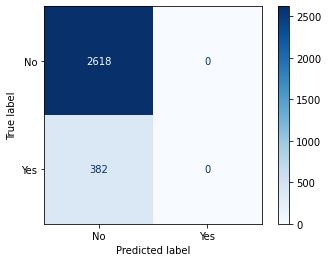

In [ ]:
# Examine the evaluation results on testing data: confusion_matrix
plot_confusion_matrix(model_svm4, predictors_test_car, target_test_car, cmap=plt.cm.Blues, values_format='d')

In [ ]:
# Examine the evaluation results on testing data: accuracy, precision, recall, and f1-score
print(classification_report(target_test_car, prediction_on_test_car))

              precision    recall  f1-score   support

          No       0.87      1.00      0.93      2618
         Yes       0.00      0.00      0.00       382

    accuracy                           0.87      3000
   macro avg       0.44      0.50      0.47      3000
weighted avg       0.76      0.87      0.81      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MLP model

In [ ]:
#Build MLP model contains two hidden layers: 16 hidden nodes for the first layer, and 10 hidden nodes for the second layer. Set random_state=1.
model_mlp3 = MLPClassifier(hidden_layer_sizes=(16, 10), random_state=1)
model_mlp3.fit(predictors_train_car, target_train_car)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Make predictions on testing data
prediction_on_test_car = model_mlp3.predict(predictors_test_car)

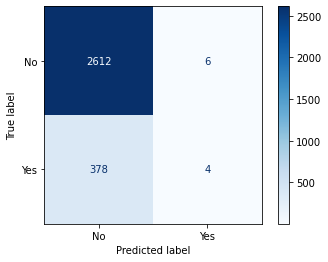

In [ ]:
# Examine the evaluation results on testing data: confusion_matrix
plot_confusion_matrix(model_mlp3, predictors_test_car, target_test_car, cmap=plt.cm.Blues, values_format='d')

In [ ]:
# Examine the evaluation results on testing data: accuracy, precision, recall, and f1-score
print(classification_report(target_test_car, prediction_on_test_car))

              precision    recall  f1-score   support

          No       0.87      1.00      0.93      2618
         Yes       0.40      0.01      0.02       382

    accuracy                           0.87      3000
   macro avg       0.64      0.50      0.48      3000
weighted avg       0.81      0.87      0.82      3000



Q5. Which model has better performance on carAuction data, SVM or neural network? why?<br>
<br>
The Neural Network proves to have better performance on the carAuction data. Their overall accuracy is the same at 0.87. Their F measure for "No" clas is also the same at 0.93
However, the SVM model did not predict any "Yes" classes and had an F measure of 0.00 for the "Yes" class while the Neural Network had an F measure of 0.02 for the "Yes" class. For this reason the MLP or Neural Network model has better performance.


***Download the html file and submit to BeachBoard***<br>
<br>
1.   ***Download the lab7.ipynb file***
2.   ***Upload the lab7.ipynb file***
3.   ***Run the code below to generate a html file***
4.   ***Download the html file and submit to BeachBoard***

In [ ]:
!jupyter nbconvert --to html IS470_lab7EC.ipynb

[NbConvertApp] Converting notebook IS470_lab7EC.ipynb to html
[NbConvertApp] Writing 429476 bytes to IS470_lab7EC.html
